In [3]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm
from copy import deepcopy

Decoding Pump activation given neural data

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [48]:
df = pd.read_hdf("data/ID18150/Day2/DataFrame_Imaging_dFF_18150_day2.h5")

In [49]:
# Get a list of columns whose names are of numerical type
numerical_columns = [col for col in df.columns if type(col) == int]

#Feature matrix
X = df[numerical_columns].values
t = df.Time.to_list()

In [50]:
delta = 5000
def get_x_ticks(L:int):
    x_ticks = np.arange(0,L,delta)
    x_tick_labels = [f"{t[i]/100:.2f}" for i in x_ticks]
    return x_ticks, x_tick_labels

In [51]:
split = int(0.2*len(X))
X_train, X_test = X[:-split], X[-split:]
y_train, y_test = df["Pump"].values[:-split], df["Pump"].values[-split:]
X_train.shape, X_test.shape

((52796, 709), (13198, 709))

In [92]:
def fibonacci(n):
    fib_sequence = [1, 2]
    while len(fib_sequence) < n:
        fib_sequence.append(fib_sequence[-1] + fib_sequence[-2])
    return fib_sequence[:n]

## Autoencoder

This model works on the hypothesis that a response $X(t)$ is caused by a lagged stimulus $y(t - \tau)$. Thus, it tries to map $X(t + \tau) \mapsto y(t)$ by reversing time and taking a certain lag window of size $\tau$. The bottleneck of this model happens inside of the GRU, as a reduction of the hidden dimension.

In [52]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, window_size = 512):
        self.X = X
        self.y = y
        self.window_size = window_size

    def __len__(self):
        return self.X.shape[0] - self.window_size

    def __getitem__(self, idx):
        y = self.y[idx]
        U = self.X[idx:idx+self.window_size]
        U = torch.tensor(U.copy(), dtype=torch.float32).T.to(device)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        return U, y

Checking the effect of window size on the model.

In [97]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_dim, conv_dim, hidden_size):
        super(AutoEncoder, self).__init__()
        self.conv_dim = conv_dim
        self.hidden_size = hidden_size
        self.dropout = torch.nn.Dropout(0.1)

        self.conv = torch.nn.Conv1d(in_channels=input_dim, out_channels=input_dim, kernel_size=conv_dim)
        self.rnn = torch.nn.GRU(input_size=input_dim, hidden_size=hidden_size, num_layers=1)
        self.fc = torch.nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.dropout(x)
        x = self.conv(x) #N, C, L
        x = torch.permute(x, (2, 0, 1))
        x, _ = self.rnn(x)
        x = torch.permute(x, (1, 0, 2))
        x = x[:,-1,:]
        x = self.fc(x)
        return x

In [98]:
input_dim = X_train.shape[1]

total_losses = []
scores = []
best_model = None
best_y_pred = []
for window_size in fibonacci(8):
    conv_size = min(8, window_size)
    model = AutoEncoder(input_dim, conv_size, 8).to(device)
    data = Dataset(X_train, y_train, window_size=window_size)
    loader = torch.utils.data.DataLoader(data, batch_size=1024, shuffle=True)
    loss = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    losses = []
    pbar = tqdm(range(5))
    for epoch in pbar:
        for X_batch, y_batch in loader:
            optimizer.zero_grad()
            y_pred_logits = model(X_batch)
            l = loss(y_pred_logits, y_batch)
            l.backward()
            optimizer.step()
            losses.append(l.item())
        pbar.set_postfix({"Loss":l.item(), "Window Size": window_size})
        scheduler.step()
    total_losses.append(losses)


    # Prepare the test dataset
    test_data = Dataset(X_test, y_test, window_size=window_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=512, shuffle=False)

    # Get predictions for the test data
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_true.extend(y_batch.cpu().numpy())
            y_pred_logits = model(X_batch)
            y_pred_sig = torch.sigmoid(y_pred_logits)
            y_pred.extend(y_pred_sig.cpu().numpy())

    # Calculate R² score
    r2 = r2_score(y_true, y_pred)
    scores.append(r2)

    if r2 == max(scores):
        best_model = deepcopy(model)
        best_y_pred = y_pred
    del model

    #Wipe CUDA memory
    if device.type == "cuda":
        torch.cuda.empty_cache()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 248.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 193.81 MiB is free. Process 155169 has 1.71 GiB memory in use. Including non-PyTorch memory, this process has 1.29 GiB memory in use. Of the allocated memory 940.76 MiB is allocated by PyTorch, and 297.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

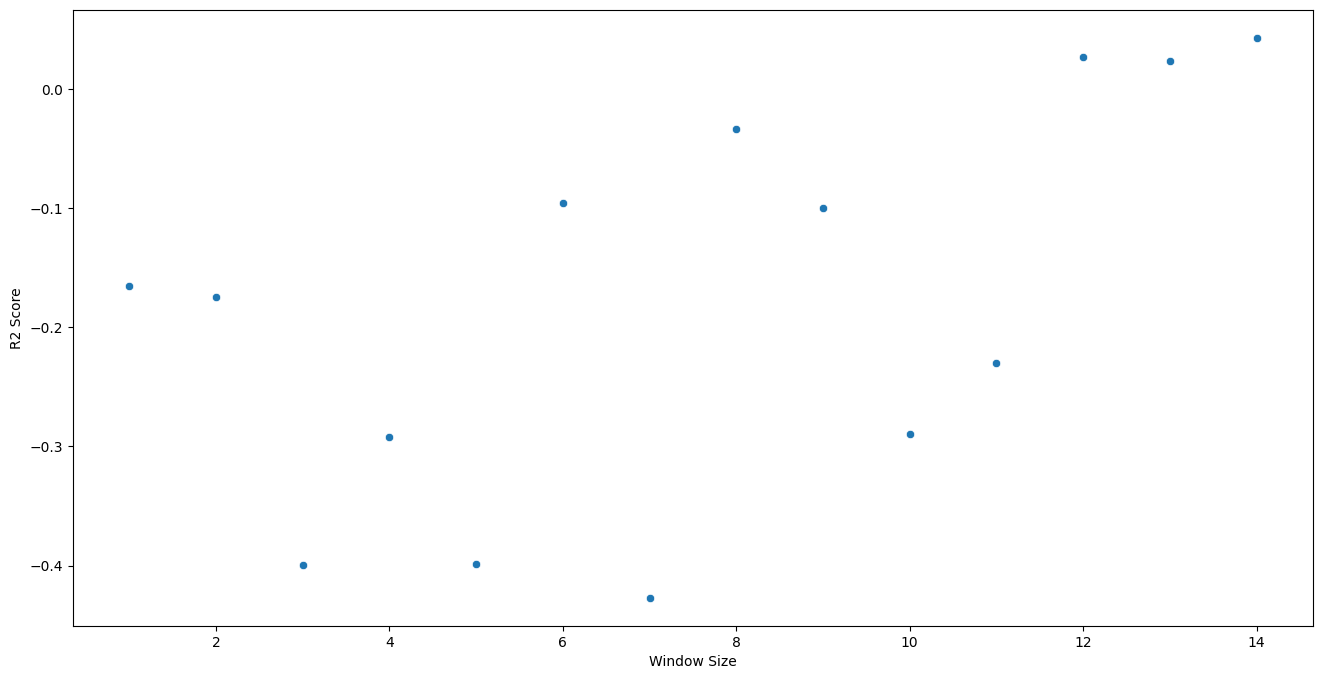

In [68]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.scatterplot(x=window_sizes, y=scores, ax=ax)
plt.xlabel('Window Size')
plt.ylabel('R2 Score')
plt.show()

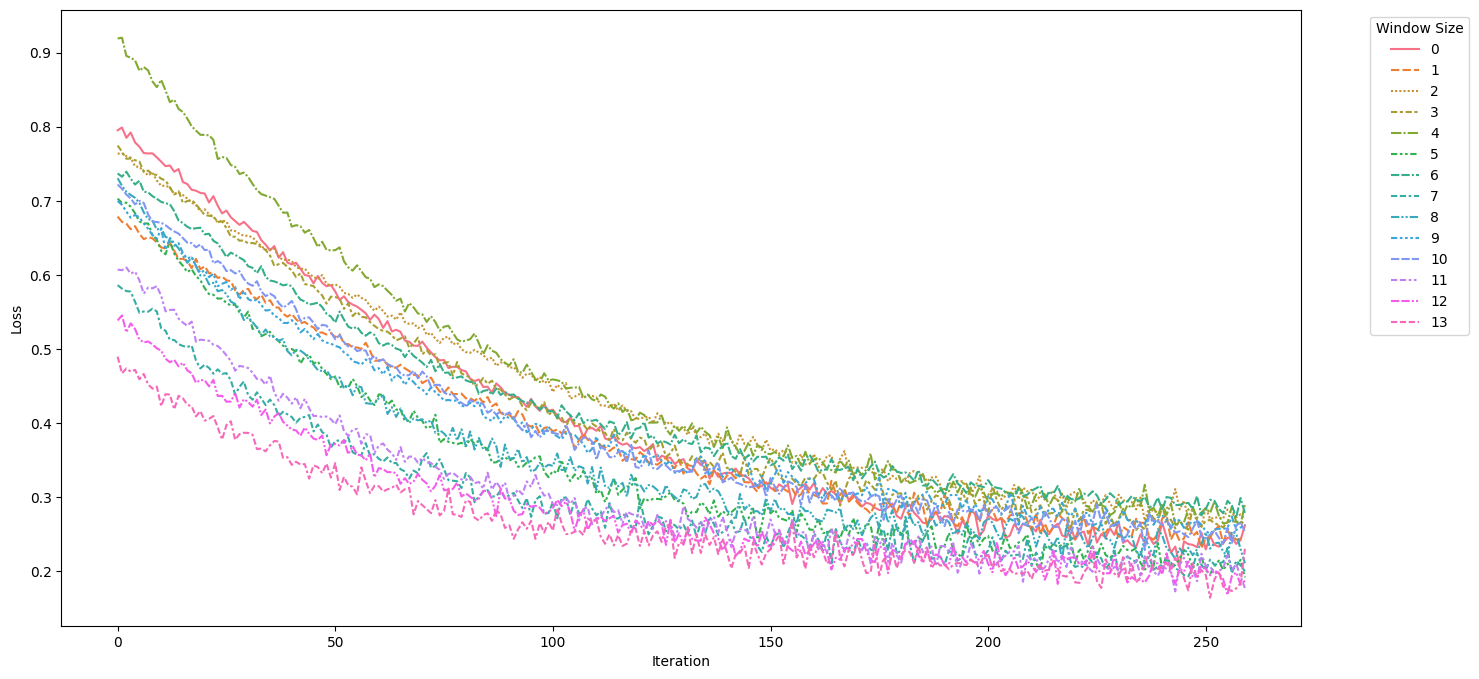

In [69]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(data=total_losses, ax=ax)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Window Size')
plt.show()

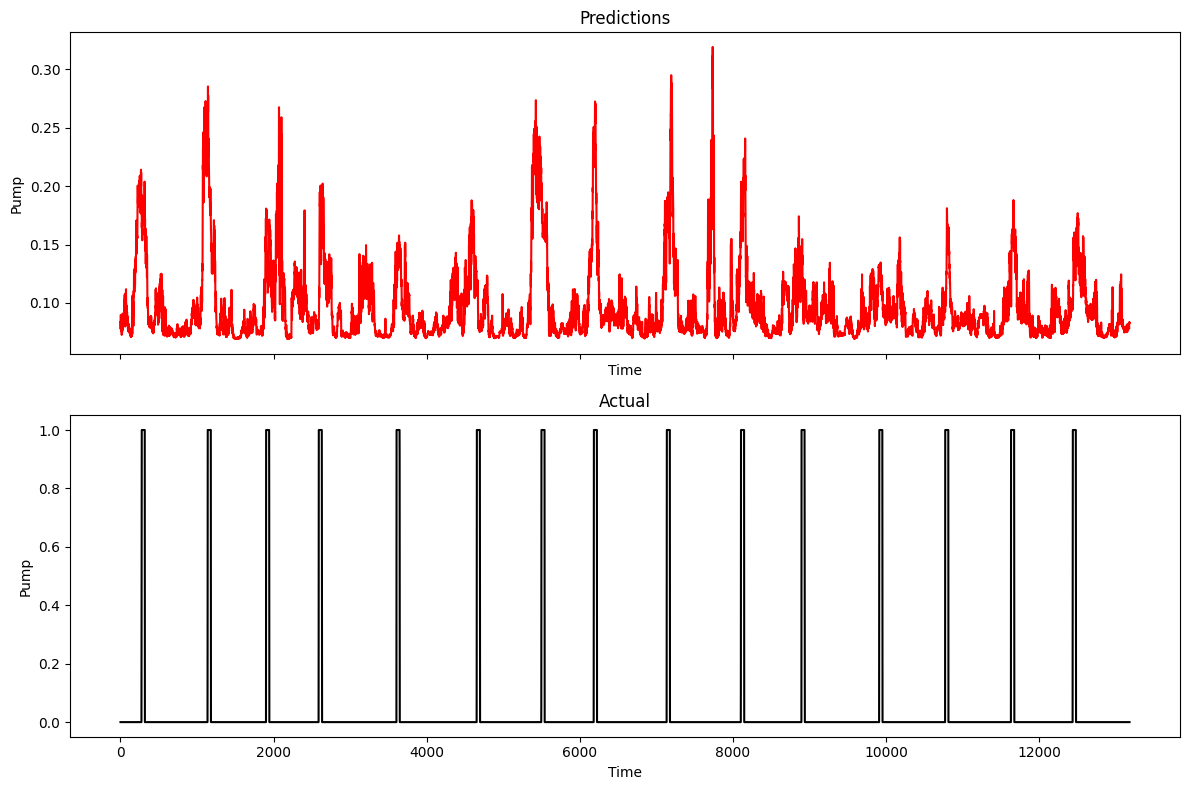

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot Pump data
ax2.plot(y_true, color='black')
ax2.set_xlabel('Time')
ax2.set_ylabel('Pump')
ax2.set_title('Actual')

# Plot predictions
ax1.plot(best_y_pred, color='red')
ax1.set_xlabel('Time')
ax1.set_ylabel('Pump')
ax1.set_title('Predictions')

plt.tight_layout()
plt.show()